In [ ]:
!pip install flatten_dict
!pip install hdbscan
!pip install bayesian-optimization==1.3.0
!pip install networkx
!pip install python-louvain
!pip install pyvis
!pip install ipython
!pip install umap-learn
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 22.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039289 sha256=ba0b7281368aa61da500eeb6f463bdb5637ebbe1d63365df163a8137a9990c0c
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
Successfully built hdbscan
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.9
    Uninstalling Cython-3.0.9:
      Successfully uninstalled Cython-3.0.9
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/9

In [ ]:
import json
import os
import pandas as pd
import numpy as np
from flatten_dict import flatten
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import calendar
import warnings
from scipy.sparse import hstack,csr_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import hdbscan
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from bayes_opt import BayesianOptimization
from sklearn.metrics import silhouette_score
from sklearn.ensemble import IsolationForest
from itertools import combinations
from collections import Counter
import networkx as nx
import matplotlib.colors as mcolors
import ast
from networkx.algorithms import bipartite
from community import community_louvain
from pyvis.network import Network
from IPython.core.display import display, HTML
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**extract_tweet_hashtag**

---


Cette fonction vise à extraire des informations détaillées liées au tweet lui-même, y compris les hashtags qu'il contient. Elle retourne un dictionnaire contenant l'identifiant du tweet, la date de création, la langue, le code pays et le nom du pays (si disponibles), le type et le nom du lieu (si disponibles), les coordonnées (si disponibles), le nombre de hashtags et une liste des hashtags présents dans le tweet.

**extract_quote_status**

---


Cette fonction extrait les informations concernant le statut cité dans un tweet (si le tweet est une citation d'un autre tweet). Elle renvoie un dictionnaire avec l'identifiant du tweet cité, l'identifiant utilisateur sous forme de chaîne de caractères et le nom d'utilisateur (screen name) de l'auteur du tweet cité.

**extract_user_mentions**

---


Cette fonction est conçue pour récupérer les informations relatives aux mentions d'utilisateurs dans un tweet. Elle produit un dictionnaire comprenant le nombre de mentions d'utilisateurs, une liste de leurs identifiants sous forme de chaîne de caractères, et une liste de leurs noms d'utilisateur.

**extract_hashtag_retweet**

---


Cette fonction se focalise sur l'extraction des hashtags présents dans un retweet. Elle retourne un dictionnaire contenant l'identifiant du tweet original retweeté et une liste des hashtags qui y sont associés.

**extract_user_info**

---


Finalement, cette fonction extrait les informations liées à l'utilisateur qui a posté le tweet. Le dictionnaire retourné inclut l'identifiant de l'utilisateur, le nombre d'amis (autres utilisateurs suivis par cet utilisateur) et la date de création du compte de l'utilisateur.

In [ ]:
def extract_tweet_hashtag(tweet):
    hashtag_info = {
        'tweet_id': tweet.get('id'),
        'tweet_created_at': tweet.get('created_at'),
        'tweet_lang': tweet.get('lang'),
        'tweet_country_code': None,
        'tweet_country': None,
        'tweet_place_type': None,
        'tweet_place_name': None,
        'tweet_coordinates': [],
        'tweet_nbr_hashtags':None,
        'tweet_hashtags': []
    }

    place = tweet.get('place',None)
    if place:
        hashtag_info.update({
            'tweet_country_code': tweet.get('place.country_code',None),
            'tweet_country': tweet.get('place.country',None),
            'tweet_place_type': tweet.get('place.place_type',None),
            'tweet_place_name': tweet.get('place.name',None),
            'tweet_coordinates': tweet.get('place.bounding_box.coordinates',[])
        })

    hashtags = tweet.get('entities.hashtags',None)
    if hashtags:
        hashtag_info.update({
            'tweet_nbr_hashtags': len(hashtags),
            'tweet_hashtags': [hashtag['text'] for hashtag in hashtags if 'text' in hashtag]
        })

    return hashtag_info

def extract_quote_status(tweet):
    quote_status_info = {
        'quoted_status_id_tweet':None,
        'quote_status_id_str':None,
        'quote_status_id_screen_name':None,
    }

    is_quote_status = tweet.get('is_quote_status',False)
    if is_quote_status:
        quote_status_info.update({
            'quoted_status_id_tweet':tweet.get('quoted_status.id_str',None),
            'quote_status_id_str': tweet.get('quoted_status.user.id_str',None),
            'quote_status_id_screen_name': tweet.get('quoted_status.user.screen_name',None)
        })

    return quote_status_info

def extract_user_mentions(tweet):
    user_mentions_info = {
        'user_mentions_nbr':None,
        'user_mentions_ids_str': [],
        'user_mentions_screen_name':[]
    }

    user_mentions = tweet.get('entities.user_mentions',None)
    if user_mentions:
        user_mentions_info.update({
            'user_mentions_nbr': len(user_mentions),
            'user_mentions_ids_str' : [mention.get('id_str') for mention in user_mentions],
            'user_mentions_screen_name': [mention.get('screen_name') for mention in user_mentions]
        })

    return user_mentions_info

def extract_hashtag_retweet(tweet):
    retweet_info = {
        'retweet_id': tweet.get('retweeted_status.id_str',None),
        'retweet_hashtags':[]
    }

    hashtags_retweet = tweet.get('retweeted_status.entities.hashtags',None)
    if hashtags_retweet:
        retweet_info.update({
            'retweet_hashtags_nbr': len(hashtags_retweet),
            'retweet_hashtags': [hashtag['text'] for hashtag in hashtags_retweet if 'text' in hashtag]
        })

    return retweet_info

def extract_user_info(tweet):
    return {
        'user_id': tweet.get('user.id',None),
        'user_screen_name': tweet.get('user.screen_name',None),
        'user_friends_count': tweet.get('user.friends_count',None),
        'user_create_at': tweet.get('user.created_at',None)
    }

In [ ]:
%%time
def convertion_json(json_object):
    converted_json = json.loads(json_object)
    converted_json = flatten(converted_json, reducer='dot')
    return converted_json

def readjsonfiles3(directory_path):
    to_return = []
    files_in_dir = os.listdir(directory_path)

    for filename in files_in_dir:
        if filename.endswith('.json'):
            file_path = os.path.join(directory_path, filename)
            file = open(file_path, 'r',encoding='utf-8')
            lines = file.readlines()
            for line in lines:
                tweet = convertion_json(line)
                dict_extract_user_info = extract_user_info(tweet)
                dict_extract_tweet_hashtag = extract_tweet_hashtag(tweet)
                dict_extract_user_mentions = extract_user_mentions(tweet)
                dict_extract_hashtag_retweet = extract_hashtag_retweet(tweet)
                dict_extract_quote_status = extract_quote_status(tweet)

                dict_extract_concatene = {**dict_extract_user_info,
                            **dict_extract_tweet_hashtag,
                            **dict_extract_user_mentions,
                            **dict_extract_hashtag_retweet,
                            **dict_extract_quote_status}
                to_return.append(dict_extract_concatene)
            file.close()
    return to_return

files_directory = "drive/MyDrive/raw"
tweet_list_enrichi = readjsonfiles3(files_directory)

CPU times: user 19min 42s, sys: 25.4 s, total: 20min 7s
Wall time: 35min 13s


# Interprétation des indicateurs en sortie de l'API

In [ ]:
# Exemple d'extraction d'indicateur pour un tweet avec les fonction ci-dessus
{'user_id': 39084553,
  'user_friends_count': 826,
  'user_create_at': 'Sun May 10 17:53:13 +0000 2009',
  'tweet_id': 1007083805889449985,
  'tweet_created_at': 'Thu Jun 14 02:14:24 +0000 2018',
  'tweet_lang': 'en',
  'tweet_country_code': None,
  'tweet_country': None,
  'tweet_place_type': None,
  'tweet_place_name': None,
  'tweet_coordinates': [],
  'tweet_nbr_hashtags': 2,
  'tweet_hashtags': ['WorldCup', 'United2026'],
  'user_mentions_nbr': 1,
  'user_mentions_ids_str': ['19077044'],
  'user_mentions_screen_name': ['HoustonRockets'],
  'retweet_id': '1006976904585498624',
  'retweet_hashtags': ['WorldCup', 'United2026'],
  'quoted_status_id_tweet': None,
  'quote_status_id_str': None,
  'quote_status_id_screen_name': None}

{'user_id': 39084553,
 'user_friends_count': 826,
 'user_create_at': 'Sun May 10 17:53:13 +0000 2009',
 'tweet_id': 1007083805889449985,
 'tweet_created_at': 'Thu Jun 14 02:14:24 +0000 2018',
 'tweet_lang': 'en',
 'tweet_country_code': None,
 'tweet_country': None,
 'tweet_place_type': None,
 'tweet_place_name': None,
 'tweet_coordinates': [],
 'tweet_nbr_hashtags': 2,
 'tweet_hashtags': ['WorldCup', 'United2026'],
 'user_mentions_nbr': 1,
 'user_mentions_ids_str': ['19077044'],
 'user_mentions_screen_name': ['HoustonRockets'],
 'retweet_id': '1006976904585498624',
 'retweet_hashtags': ['WorldCup', 'United2026'],
 'quoted_status_id_tweet': None,
 'quote_status_id_str': None,
 'quote_status_id_screen_name': None}

Identifiant de l'utilisateur (user_id): Le tweet a été publié par l'utilisateur ayant l'identifiant 39084553.

---


Nombre d'amis de l'utilisateur (user_friends_count): L'utilisateur avait 826 amis au moment de la publication du tweet.

---


Date de création du compte utilisateur (user_create_at): Le compte de l'utilisateur a été créé le 10 mai 2009 à 17h53 UTC.

---


Identifiant du tweet (tweet_id): L'identifiant unique de ce tweet est 1007083805889449985.

---


Date de création du tweet (tweet_created_at): Le tweet a été publié le 14 juin 2018 à 02h14 UTC.

---


Langue du tweet (tweet_lang): Le tweet est en anglais (en).

---


Code du pays et nom du pays (tweet_country_code, tweet_country): Ces informations ne sont pas disponibles pour ce tweet (None), ce qui signifie qu'il n'est pas associé à un pays spécifique.

---


Type et nom du lieu (tweet_place_type, tweet_place_name): Ces informations ne sont également pas disponibles (None), indiquant que le tweet n'a pas été publié avec des informations de localisation précises.

---


Coordonnées (tweet_coordinates): Aucune coordonnée géographique n'est associée à ce tweet, comme indiqué par une liste vide [].

---


Nombre de hashtags et hashtags utilisés (tweet_nbr_hashtags, tweet_hashtags): Le tweet contient 2 hashtags, WorldCup et United2026.

---


Nombre de mentions d'utilisateurs et informations sur ces mentions (user_mentions_nbr, user_mentions_ids_str, user_mentions_screen_name): Le tweet mentionne 1 utilisateur, avec l'identifiant 19077044 et le nom d'écran HoustonRockets.

---


Informations sur le retweet (retweet_id, retweet_hashtags): Ce tweet est un retweet de l'identifiant 1006976904585498624, et il contient les mêmes hashtags que le tweet original, à savoir WorldCup et United2026.

---


Statut de citation (quoted_status_id_tweet, quote_status_id_str, quote_status_id_screen_name): Ce tweet ne cite pas un autre tweet, comme indiqué par les valeurs None.

# Importation des données dans un dataframe

In [ ]:
df_initial = pd.DataFrame(tweet_list_enrichi)
df_initial['tweet_created_at'] = pd.to_datetime(df_initial['tweet_created_at'], format='%a %b %d %H:%M:%S +0000 %Y')
df_initial.set_index('tweet_created_at', inplace=True)
print(df_initial.shape)
df_initial.head()

(4567999, 22)


,user_id,user_screen_name,user_friends_count,user_create_at,tweet_id,tweet_lang,tweet_country_code,tweet_country,tweet_place_type,tweet_place_name,...,tweet_hashtags,user_mentions_nbr,user_mentions_ids_str,user_mentions_screen_name,retweet_id,retweet_hashtags,quoted_status_id_tweet,quote_status_id_str,quote_status_id_screen_name,retweet_hashtags_nbr
tweet_created_at,,,,,,,,,,,,,,,,,,,,,
2018-06-17 14:44:48,83872552,EderArreola7,371,Tue Oct 20 16:07:38 +0000 2009,1008359811694538752,es,None,None,None,None,...,[WorldCup],NaN,[],[],None,[],None,None,None,NaN
2018-06-17 14:44:48,274539150,Edwin_Mills,402,Wed Mar 30 14:00:06 +0000 2011,1008359812940300288,en,None,None,None,None,...,"[WorldCup, DieMannschaft, ZSMMN, GERMEX]",1.0,[2350218440],[DFB_Team_EN],1008346440375132160,"[WorldCup, DieMannschaft, ZSMMN, GERMEX]",None,None,None,4.0
2018-06-17 14:44:48,561442587,Cristianity_17,280,Mon Apr 23 18:22:44 +0000 2012,1008359813250613250,en,None,None,None,None,...,"[CRC, SRB, WorldCup]",1.0,[4572365572],[MyTentOrGeorge],1008337448554856449,"[CRC, SRB, WorldCup]",None,None,None,3.0
2018-06-17 14:44:48,586925350,TorchysBar,1950,Mon May 21 22:08:41 +0000 2012,1008359812982296577,en,None,None,None,None,...,[],NaN,[],[],None,[],1008351782345543680,3260148888,CBSSportsSoccer,NaN
2018-06-17 14:44:48,2378839073,Lynou8813,2025,Mon Mar 03 10:24:48 +0000 2014,1008359814135762946,fr,None,None,None,None,...,"[allezlesbleus, fiersdetrebleus, weliveforfoot...",2.0,"[2491702663, 2155215398]","[paulpogba, equipedefrance]",1008354741397704705,"[allezlesbleus, fiersdetrebleus, weliveforfoot...",None,None,None,5.0


## Exploration

In [ ]:
df = df_initial.copy()
# Mettre en minuscule tous les hashtags et user mentions avant le filtrage
df['user_screen_name'] = df['user_screen_name'].apply(lambda x: x.lower())
df['tweet_hashtags'] = df['tweet_hashtags'].apply(lambda x: [tag.lower() for tag in x])
df['user_mentions_screen_name'] = df['user_mentions_screen_name'].apply(lambda x: [tag.lower() for tag in x])
df['retweet_hashtags'] = df['retweet_hashtags'].apply(lambda x: [tag.lower() for tag in x])

In [ ]:
all_hashtags_tweet = pd.Series([hashtag for sublist in df['tweet_hashtags'].dropna() for hashtag in sublist])
all_hashtags_tweet.reset_index(drop=True, inplace=True)
hashtag_tweet_frequence = all_hashtags_tweet.value_counts().sort_values(ascending = False)[:50] # top 50 des hashtags utilisés dans les tweets
print(hashtag_tweet_frequence)
hashtags_plot = list(hashtag_tweet_frequence.index)

worldcup              2815204
worldcup2018           260149
russia2018             137131
poresp                 132580
por                    112797
esp                    101683
worldcuprussia2018      92062
rusksa                  87881
rus                     83074
isl                     76460
rusia2018               75487
germex                  74848
cronga                  74217
mex                     69945
arg                     67084
argisl                  64948
egy                     60242
ksa                     60217
ger                     55043
fra                     50269
egyuru                  47440
fraaus                  46184
uru                     42626
cro                     38793
nga                     38661
ワールドカップ                 38115
aus                     33225
irn                     32420
russia                  29561
srb                     29521
copa2018                28641
diemannschaft           28628
messi                   28368
per       

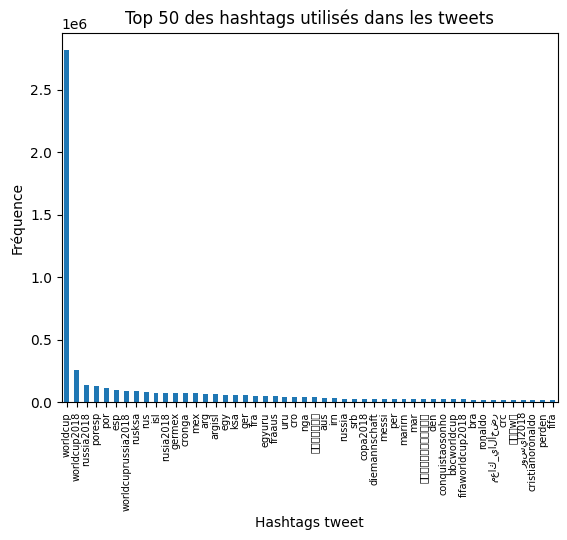

In [ ]:
hashtag_tweet_frequence.plot(kind='bar')
plt.title('Top 50 des hashtags utilisés dans les tweets')
plt.xlabel('Hashtags tweet')
plt.ylabel('Fréquence')
plt.xticks(rotation=90, fontsize=7)
plt.show()

In [ ]:
all_hashtags_retweet = pd.Series([hashtag for sublist in df['retweet_hashtags'].dropna() for hashtag in sublist])
all_hashtags_retweet.reset_index(drop=True, inplace=True)
hashtag_retweet_frequence = all_hashtags_retweet.value_counts().sort_values(ascending = False)[:50] # top 50 des hashtags utilisés dans les retweets
print(hashtag_retweet_frequence)
hashtags_plot = list(hashtag_retweet_frequence.index)

worldcup              1843037
worldcup2018           123165
poresp                  95735
por                     84461
russia2018              77513
esp                     74219
rusksa                  69967
rus                     55876
isl                     53253
cronga                  53109
worldcuprussia2018      51803
germex                  48404
ksa                     44528
mex                     43831
arg                     42193
egy                     41809
argisl                  41248
rusia2018               38523
fra                     31359
egyuru                  31076
ger                     30809
ワールドカップ                 30310
uru                     25673
cro                     25491
nga                     24505
diemannschaft           24331
conquistaosonho         23262
fraaus                  22364
irn                     20548
messi                   20014
srb                     19830
สวัสดีบอลโลก            19791
russia                  18553
aus       

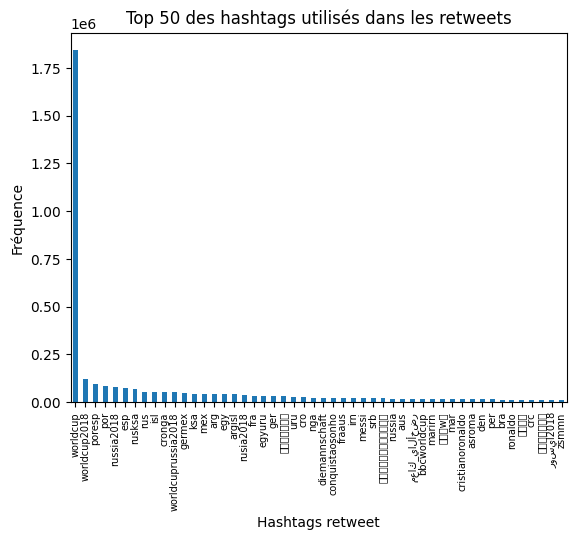

In [ ]:
hashtag_retweet_frequence.plot(kind='bar')
plt.title('Top 50 des hashtags utilisés dans les retweets')
plt.xlabel('Hashtags retweet')
plt.ylabel('Fréquence')
plt.xticks(rotation=90, fontsize=7)
plt.show()

In [ ]:
all_user_tweet = pd.Series([user for user in df['user_screen_name'].dropna()])
all_user_tweet.reset_index(drop=True, inplace=True)
user_tweet_frequence = all_user_tweet.value_counts().sort_values(ascending = False)[:50] # top 50 des users qui publient le plus de tweet
print(user_tweet_frequence)
hashtags_plot = list(user_tweet_frequence.index)

fcbtweetbot        7143
dreakeroh2222      2731
daminous_purity    2674
victory_goal       1433
fifarussia2k18     1284
andycramp3         1139
hidayat64341768    1050
prakai_bu          1049
stevebrookes69      985
hugebetting         968
rico_utd95          900
ibetomuller         867
prince_david_gh     863
alf_10cfc           855
escortscrnet        721
mexicostats_18      702
targetsucks4        676
vedanthrathod1      673
supersporttv        672
footballtips        663
prosyria1           582
cup_quiz            579
nicheachem          571
fivestarfooty       558
potongkelape        553
ifutbola            534
finnwonderland      526
rarararambo217      515
arthurd0n94         515
bbcmotd             509
lopezgovlaw         494
worldfitjapan       474
pisudavi            474
kknath26            472
tec_arrowhead       468
hashtagspiruli      463
livefootball        449
martinchab10        437
rotananet           426
actindbuilding      426
iamwbis             425
televisionjam   

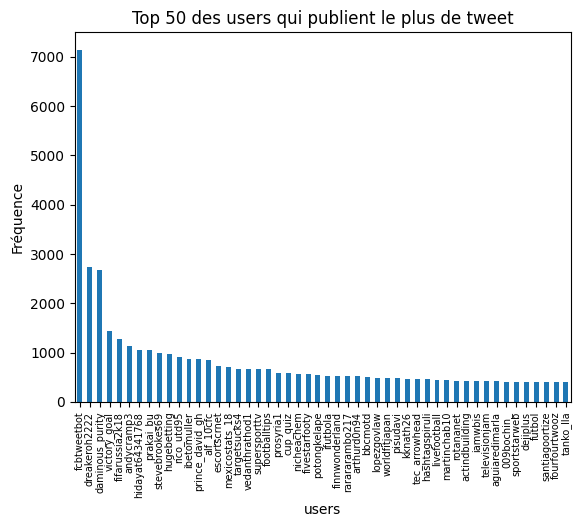

In [ ]:
user_tweet_frequence.plot(kind='bar')
plt.title('Top 50 des users qui publient le plus de tweet')
plt.xlabel('users')
plt.ylabel('Fréquence')
plt.xticks(rotation=90, fontsize=7)
plt.show()

In [ ]:
users_plus_actif = df['user_screen_name'].value_counts().head(50).index # top 50 des users qui publient le plus de tweet
df_filtre_user_plus_actif = df[df['user_screen_name'].isin(users_plus_actif)]
df_nbr_moyen_hashtags_user = df_filtre_user_plus_actif.groupby('user_screen_name')['tweet_nbr_hashtags'].mean()
print(df_nbr_moyen_hashtags_user)

user_screen_name
009bochin_         3.114130
actindbuilding     2.116848
aguiaredimarla     2.648352
alf_10cfc          2.418792
andycramp3         2.449119
arthurd0n94        1.907527
bbcmotd            2.377215
cup_quiz           2.053830
daminous_purity    8.229213
dejiplus           2.682796
dreakeroh2222      2.161429
escortscrnet       3.012483
fcbtweetbot        2.304305
fifarussia2k18     2.382589
finnwonderland     2.074627
fivestarfooty      2.775148
footballtips       2.014563
fourfourtwooz      2.742972
futbol             1.103896
hashtagspiruli     5.811816
hidayat64341768    3.315238
hugebetting        1.000000
iamwbis            3.280098
ibetomuller        1.859397
ifutbola           2.065022
kknath26           2.113253
livefootball       1.146635
lopezgovlaw        3.547739
martinchab10       2.839599
mexicostats_18     2.253968
nicheachem         1.971979
pisudavi           2.551570
potongkelape       2.087719
prakai_bu          3.084650
prince_david_gh    2.035139
pro

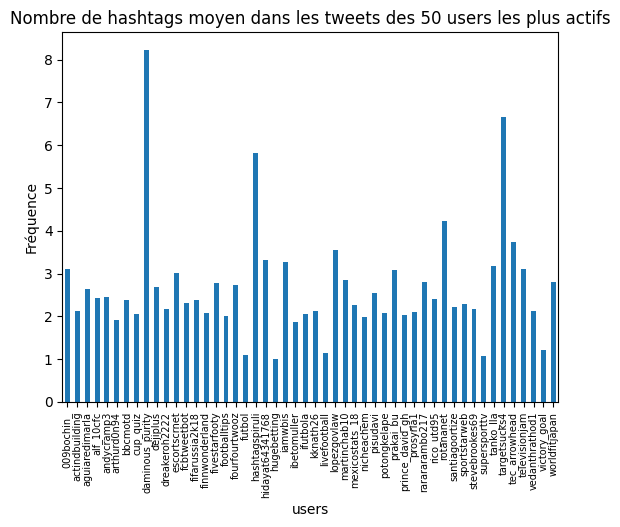

In [ ]:
df_nbr_moyen_hashtags_user.plot(kind='bar')
plt.title('Nombre de hashtags moyen dans les tweets des 50 users les plus actifs')
plt.xlabel('users')
plt.ylabel('Fréquence')
plt.xticks(rotation=90, fontsize=7)
plt.show()

# Application d'un algo de détection d'anomalie dans le dataframe

## Préparation des données

In [ ]:
df_filtre = df.copy()
# Filtrer les lignes pour exclure les tweets contenant worldcup dans les hashtags de tweets ou de retweets
df_filtre = df_filtre[
    ~(
        df_filtre['tweet_hashtags'].apply(lambda x: any('worldcup' in tag.lower() for tag in x)) |
        df_filtre['retweet_hashtags'].apply(lambda x: any('worldcup' in tag.lower() for tag in x))
    )
]
print(df_filtre.shape)
df_filtre.head()

(1492395, 22)


,user_id,user_screen_name,user_friends_count,user_create_at,tweet_id,tweet_lang,tweet_country_code,tweet_country,tweet_place_type,tweet_place_name,...,tweet_hashtags,user_mentions_nbr,user_mentions_ids_str,user_mentions_screen_name,retweet_id,retweet_hashtags,quoted_status_id_tweet,quote_status_id_str,quote_status_id_screen_name,retweet_hashtags_nbr
tweet_created_at,,,,,,,,,,,,,,,,,,,,,
2018-06-17 14:44:48,586925350,torchysbar,1950,Mon May 21 22:08:41 +0000 2012,1008359812982296577,en,None,None,None,None,...,[],NaN,[],[],None,[],1008351782345543680,3260148888,CBSSportsSoccer,NaN
2018-06-17 14:44:48,99153026,aileen_montana,4668,Thu Dec 24 18:57:39 +0000 2009,1008359814240636930,en,None,None,None,None,...,[nadanosdetiene],2.0,"[3253879915, 138372303]","[miseleccionmxen, fifaworldcup]",1008350237822476288,[nadanosdetiene],None,None,None,1.0
2018-06-17 14:44:48,1535154438,johnzaum_,430,Thu Jun 20 22:31:09 +0000 2013,1008359814274183168,pt,None,None,None,None,...,[],NaN,[],[],None,[],None,None,None,NaN
2018-06-17 14:44:49,316820343,thecodymccarty,305,Tue Jun 14 00:56:40 +0000 2011,1008359815205310464,en,None,None,None,None,...,[],1.0,[628706570],[basedchasen],1008305498184011776,[],1008302287444480000,138372303,FIFAWorldCup,NaN
2018-06-17 14:44:49,379477612,bambi_wilai,649,Sun Sep 25 01:33:32 +0000 2011,1008359815502950400,th,None,None,None,None,...,[isl],1.0,[945145639553265665],[nuncius_],1008318209831759873,[isl],1007956443541262336,3760236855,RTSportNews,1.0


### Préparation des données

In [ ]:
df_preparation= df_filtre.copy()

# Transformation des listes en chaînes séparées par des espaces pour TF-IDF
vectorizer = TfidfVectorizer()

df_preparation['hashtags_str'] = df_preparation['tweet_hashtags'].apply(lambda x: ' '.join(x))
df_preparation['user_mentions_str'] = df_preparation['user_mentions_screen_name'].apply(lambda x: ' '.join(x))
df_preparation['retweet_hashtags_str'] = df_preparation['retweet_hashtags'].apply(lambda x: ' '.join(x))

X_hashtags = vectorizer.fit_transform(df_preparation['hashtags_str'])
X_user_mentions = vectorizer.fit_transform(df_preparation['user_mentions_str'])
X_retweet_hashtags = vectorizer.fit_transform(df_preparation['retweet_hashtags_str'])

# Encodage les variables temporelles
df_preparation['year_month'] = df_preparation.index.month
df_preparation['hour'] = df_preparation.index.hour
df_preparation['minute'] = df_preparation.index.minute
df_preparation['second'] = df_preparation.index.second

# Cyclisation des mois (12 mois dans une année)
df_preparation['month_sin'] = np.sin(2 * np.pi * df_preparation['year_month'] / 12)
df_preparation['month_cos'] = np.cos(2 * np.pi * df_preparation['year_month'] / 12)

# Cyclisation des heures (24 heures dans une journée)
df_preparation['hour_sin'] = np.sin(2 * np.pi * df_preparation['hour'] / 24)
df_preparation['hour_cos'] = np.cos(2 * np.pi * df_preparation['hour'] / 24)

# Cyclisation des minutes (60 minutes dans une heure)
df_preparation['minute_sin'] = np.sin(2 * np.pi * df_preparation['minute'] / 60)
df_preparation['minute_cos'] = np.cos(2 * np.pi * df_preparation['minute'] / 60)

# Cyclisation des secondes (60 secondes dans une minutes)
df_preparation['second_sin'] = np.sin(2 * np.pi * df_preparation['second'] / 60)
df_preparation['second_cos'] = np.cos(2 * np.pi * df_preparation['second'] / 60)

temporal_features = ['month_sin', 'month_cos', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 'second_sin', 'second_cos']
X_temporal = csr_matrix(df_preparation[temporal_features].values)

# Combinaison des embeddings tf-idfet des encodages temporels
X_combined = hstack([X_hashtags, X_user_mentions, X_retweet_hashtags, X_temporal])
print(X_combined.shape)

(1492395, 159899)


## Isolation forest

In [ ]:
%%time
# Définition de la fonction objectif pour l'optimisation des hyperparamètre de l'algo
def iforest_score(n_estimators, max_samples, contamination):
    n_estimators = int(n_estimators)
    max_samples = max(0.1, min(1, max_samples))
    contamination = max(0.001, min(0.5, contamination))

    iforest = IsolationForest(n_estimators=n_estimators,
                              max_samples=max_samples,
                              contamination=contamination,
                              random_state=42)
    iforest.fit(X_combined)
    scores = iforest.decision_function(X_combined)
    performance_metric = np.mean(scores)

    return performance_metric

# espace des hyperparamètres
pbounds = {
    'n_estimators': (50, 300),
    'max_samples': (0.1, 1),
    'contamination': (0.001, 0.05)
}

# Optimisation bayésienne
optimizer = BayesianOptimization(f=iforest_score, pbounds=pbounds, random_state=42)
optimizer.maximize(init_points=2, n_iter=10)

print(optimizer.max)

|   iter    |  target   | contam... | max_sa... | n_esti... |
-------------------------------------------------------------
| 1         | 0.0006307 | 0.01935   | 0.9556    | 233.0     |
| 2         | 0.001179  | 0.03033   | 0.2404    | 89.0      |
| 3         | -3.193e-0 | 0.02375   | 0.8121    | 90.18     |
| 4         | -7.489e-0 | 0.04899   | 0.2189    | 88.99     |
| 5         | 0.001149  | 0.01694   | 0.5312    | 85.7      |
| 6         | -4.477e-0 | 0.04721   | 0.4311    | 105.3     |
| 7         | -3.038e-0 | 0.04481   | 0.8754    | 153.3     |
| 8         | 0.0007368 | 0.01728   | 0.7119    | 290.8     |
| 9         | 0.00137   | 0.005627  | 0.8211    | 198.9     |
| 10        | 0.0007194 | 0.02075   | 0.8566    | 239.4     |
| 11        | 0.0007013 | 0.03091   | 0.2993    | 294.0     |
| 12        | 0.001569  | 0.003002  | 0.54      | 197.9     |
{'target': 0.001568783125835516, 'params': {'contamination': 0.003002164681234841, 'max_samples': 0.5399994133563681, 'n_estimators'

In [ ]:
%%time
best_params = optimizer.max['params']
model = IsolationForest(n_estimators=int(best_params['n_estimators']),
                        max_samples=best_params['max_samples'],
                        contamination=best_params['contamination'],
                        random_state=42)

model.fit(X_combined)
predictions = model.predict(X_combined)

df_iforest = df_filtre.copy()
df_iforest['status'] = np.where(predictions == -1, 'anormal', 'normal')

CPU times: user 21min 51s, sys: 2.73 s, total: 21min 54s
Wall time: 21min 51s


In [ ]:
df_iforest.to_csv('tweets.csv', index=False)

In [ ]:
df_detection_anomalie = pd.read_csv("drive/MyDrive/Colab Notebooks/tweets.csv")
df_detection_anomalie['tweet_created_at'] = pd.to_datetime(df_detection_anomalie['tweet_created_at'], format='%a %b %d %H:%M:%S +0000 %Y')
df_initial.set_index('tweet_created_at', inplace=True)
print(df_initial.shape)
df_initial.head()

In [ ]:
df_.head()

,user_id,user_screen_name,user_friends_count,user_create_at,tweet_id,tweet_lang,tweet_country_code,tweet_country,tweet_place_type,tweet_place_name,...,user_mentions_nbr,user_mentions_ids_str,user_mentions_screen_name,retweet_id,retweet_hashtags,quoted_status_id_tweet,quote_status_id_str,quote_status_id_screen_name,retweet_hashtags_nbr,status
0,586925350,torchysbar,1950,Mon May 21 22:08:41 +0000 2012,1008359812982296577,en,NaN,NaN,NaN,NaN,...,NaN,[],[],NaN,[],1.008352e+18,3.260149e+09,CBSSportsSoccer,NaN,normal
1,99153026,aileen_montana,4668,Thu Dec 24 18:57:39 +0000 2009,1008359814240636930,en,NaN,NaN,NaN,NaN,...,2.0,"['3253879915', '138372303']","['miseleccionmxen', 'fifaworldcup']",1.008350e+18,['nadanosdetiene'],NaN,NaN,NaN,1.0,normal
2,1535154438,johnzaum_,430,Thu Jun 20 22:31:09 +0000 2013,1008359814274183168,pt,NaN,NaN,NaN,NaN,...,NaN,[],[],NaN,[],NaN,NaN,NaN,NaN,normal
3,316820343,thecodymccarty,305,Tue Jun 14 00:56:40 +0000 2011,1008359815205310464,en,NaN,NaN,NaN,NaN,...,1.0,['628706570'],['basedchasen'],1.008305e+18,[],1.008302e+18,1.383723e+08,FIFAWorldCup,NaN,normal
4,379477612,bambi_wilai,649,Sun Sep 25 01:33:32 +0000 2011,1008359815502950400,th,NaN,NaN,NaN,NaN,...,1.0,['945145639553265665'],['nuncius_'],1.008318e+18,['isl'],1.007956e+18,3.760237e+09,RTSportNews,1.0,normal


# Analyse des occurrences de hashtags et visualisation des réseaux de hasthags

## Prétraitement des données

In [ ]:
df_co = df_iforest_normal.copy()
# on ne selectionne les tweets normaux qui comporte des hashtags
df_co = df_co[df_co['tweet_hashtags'].apply(lambda x: len(x) > 0)]


(38150, 23)
La plage temporelle va du 2018-06-14 02:14:25 au 2018-06-16 00:50:57


### Aplatir la liste des hashtags

In [ ]:
print(df_co.shape)
print(f"La plage temporelle va du {df_co.index.min()} au {df_co.index.max()}")

In [ ]:
rows = []
_ = df_co.apply(lambda row: [rows.append([(row.name).floor('H'), ht]) for ht in row['tweet_hashtags']], axis=1)
df_flat = pd.DataFrame(rows, columns=['tweet_created_at', 'hashtag'])
df_count = df_flat.groupby(['tweet_created_at', 'hashtag']).size().unstack(fill_value=0)
df_count.head()

hashtag,01f13f,042campus,042entrepreneur,100bulles,10over10,12h45rts,13reasonswhy,14dejunio,14giugno,14jun,...,香川真司,갓세븐,방탄소년단,블랙핑크,실제_이름이_흔한가요,엑소,이달의소녀,제도성배기담_사과요구,진솔,ｗ杯ロシア大会
tweet_created_at,,,,,,,,,,,,,,,,,,,,,
2018-06-14 02:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-06-14 03:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-06-14 04:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-06-14 10:00:00,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2018-06-14 11:00:00,0,0,0,0,0,1,0,0,5,2,...,1,0,0,0,0,0,0,0,0,0


### Compter les occurrences de chaque hashtag par timestamp

In [ ]:
min_timestamp = df_count.index.min()
max_timestamp = df_count.index.max()
full_timestamp_index = pd.date_range(start=min_timestamp, end=max_timestamp, freq='H')
df_filled = df_count.reindex(full_timestamp_index, fill_value=0)
df_filled.head()

hashtag,01f13f,042campus,042entrepreneur,100bulles,10over10,12h45rts,13reasonswhy,14dejunio,14giugno,14jun,...,香川真司,갓세븐,방탄소년단,블랙핑크,실제_이름이_흔한가요,엑소,이달의소녀,제도성배기담_사과요구,진솔,ｗ杯ロシア大会
2018-06-14 02:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-06-14 03:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-06-14 04:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-06-14 05:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-06-14 06:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Analyse exploratoire

In [ ]:
all_hashtags = pd.Series([hashtag for sublist in df_co['tweet_hashtags'].dropna() for hashtag in sublist])
all_hashtags.reset_index(drop=True, inplace=True)
hashtag_frequence = all_hashtags.value_counts().sort_values(ascending = False)[:15]
print(hashtag_frequence)
hashtags_plot = list(hashtag_frequence.index)

russia2018          7246
por                 5026
esp                 4181
poresp              3491
ronaldo             2401
cristiano           1999
portugal            1971
スペイン                1446
cristianoronaldo    1410
spain               1368
ポルトガル               1308
portugalvsspain     1247
conquistaosonho     1246
cr7                 1168
w杯                  1145
dtype: int64


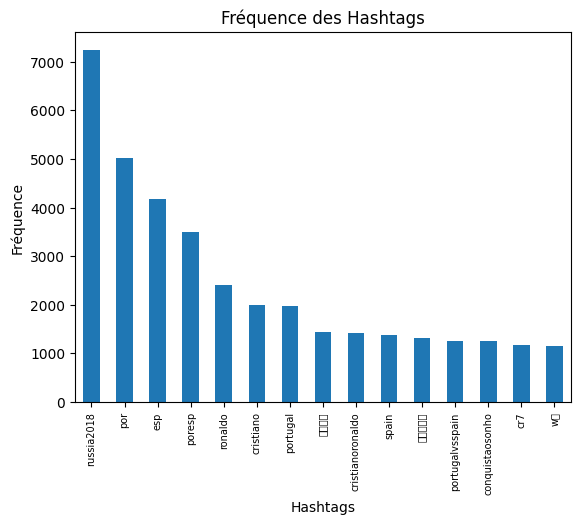

In [ ]:
hashtag_frequence.plot(kind='bar')
plt.title('Fréquence des top 15 des hashtags')
plt.xlabel('Hashtags')
plt.ylabel('Fréquence')
plt.xticks(rotation=90, fontsize=7)
plt.show()

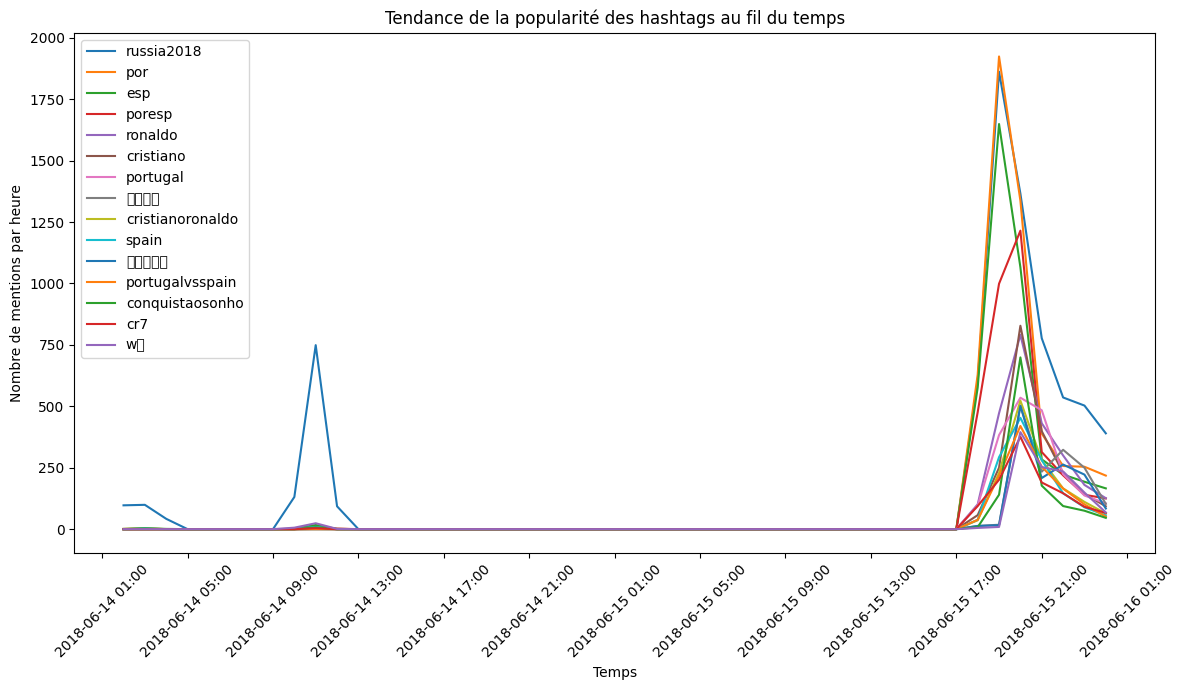

In [ ]:
plt.figure(figsize=(12, 7))
for hashtag in hashtags_plot:
    if hashtag in df_filled.columns:
        plt.plot(df_filled.index, df_filled[hashtag], label=hashtag)

plt.title('Tendance du top 15 des hashtags les plus populaire au fil du temps')
plt.xlabel('Temps')
plt.ylabel('Nombre de mentions par heure')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=4)) #ajuster l'intervalle
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
descriptive_stats = df_filled[hashtags_plot].describe().loc[['mean', '50%', 'std']]
descriptive_stats.rename(index={'50%': 'median'}, inplace=True)
descriptive_stats

hashtag,russia2018,por,esp,poresp,ronaldo,cristiano,portugal,スペイン,cristianoronaldo,spain,ポルトガル,portugalvsspain,conquistaosonho,cr7,w杯
mean,154.170213,106.936170,88.957447,74.276596,51.085106,42.531915,41.93617,30.765957,30.000000,29.106383,27.829787,26.531915,26.510638,24.851064,24.361702
median,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
std,375.354981,351.304922,295.269071,238.805424,151.804197,140.387329,121.02181,97.825535,94.166827,88.968053,91.461638,80.328903,106.647300,70.964773,77.306399


## Analyse des concurrences

In [ ]:
co_occurrences = Counter()
for hashtags in df_co['tweet_hashtags']:
    for combo in combinations(sorted(set(hashtags)), 2):
        co_occurrences[combo] += 1

df_co_occurrences = pd.DataFrame.from_dict(co_occurrences, orient='index', columns=['co-occurrence'])
df_co_occurrences.index.names = ['Hashtag Pair']

df_top20_co_occurrences = df_co_occurrences.nlargest(20, 'co-occurrence')

df_top20_co_occurrences

,co-occurrence
Hashtag Pair,
"(esp, por)",3529
"(スペイン, ポルトガル)",1306
"(portugal, spain)",1147
"(cristiano, portugal)",1099
"(cristiano, portugalvsspain)",976
"(cristianoronaldo, ronaldo)",972
"(portugal, ronaldo)",951
"(cristianoronaldo, portugal)",934
"(ronaldo, spain)",933


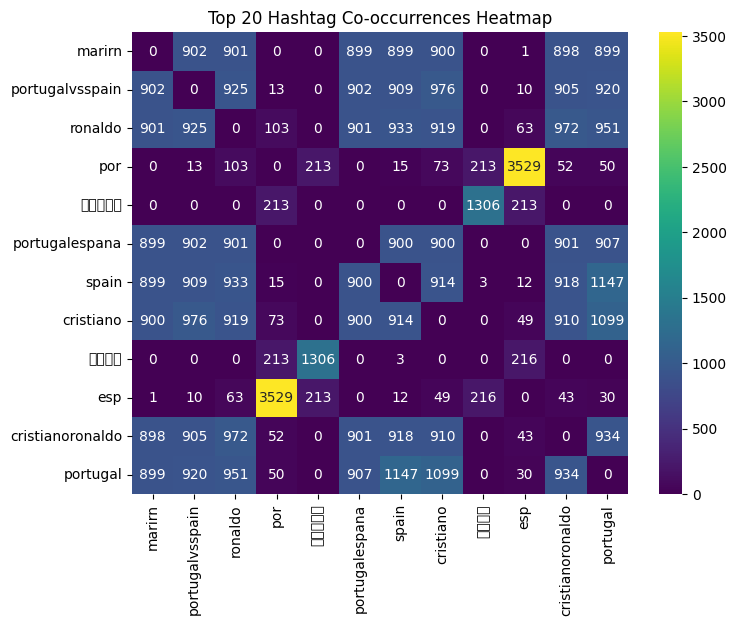

In [ ]:
hashtags = set()
for pair in df_top20_co_occurrences.index:
    hashtags.update(pair)
hashtags = list(hashtags)
matrix = pd.DataFrame(0, index=hashtags, columns=hashtags)

for (hashtag1, hashtag2), count in co_occurrences.items():
    if hashtag1 in hashtags and hashtag2 in hashtags:
        matrix.loc[hashtag1, hashtag2] = count
        matrix.loc[hashtag2, hashtag1] = count

plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, cmap='viridis', fmt='g')
plt.title('Top 20 Hashtag Co-occurrences Heatmap')
plt.show()

## Visualisation des réseaux de hashtags avec l'algorithme de détection communautaire de Louvain



In [ ]:
def community_network_viz(df, K):
    # Filtrer les arêtes par poids
    df_filtered = df.loc[df['weight'] > K]
    max_weight = max(df_filtered['weight'])

    # Création du graphe
    G = nx.from_pandas_edgelist(df_filtered, source="source", target="target", edge_attr="weight", create_using=nx.Graph())

    # Application de l'algorithme de Louvain pour détecter les communautés
    partition = community_louvain.best_partition(G)
    nx.set_node_attributes(G, partition, 'group')

    # Normaliser les poids et mettre à jour les attributs de taille des nœuds
    for _, row in df_filtered.iterrows():
        G.add_edge(row['source'], row['target'], weight=row['weight'] / max_weight)
        d = dict(G.degree)
        d.update((x, 1*y) for x, y in d.items())

    #Setting up size attribute
    nx.set_node_attributes(G,d,'size')
    net_com  = Network(height="600px",
              width="75%",
              directed=False,
              notebook=True,
              neighborhood_highlight=True,
              select_menu=True,
              bgcolor="#36454F",
              font_color='white',
              layout=None,
              cdn_resources="remote")
    net_com.repulsion()
    net_com.set_options("""var options = {"edges": {"color": {"inherit": true},"font": {"size": 50,"strokeWidth": 3},"scaling": {"max": 14},"smooth": false},"interaction": {"tooltipDelay": 100}}""")
    net_com.from_nx(G, )
    net_com.save_graph('network_viz.html')
    net_com.show('network_viz.html')
    return display(HTML('network_viz.html'))

In [ ]:
G = nx.Graph()
usernames = set()
hashtags = set()

for index, row in df_co.iterrows():
    username = row['user_screen_name']
    username = f'@{username}'

    hts = row['tweet_hashtags']
    if isinstance(hts, str):
        try:
            hts = ast.literal_eval(hts)
        except ValueError:
            hts = []
    hts = hts if isinstance(hts, list) else []
    hts = [f'#{h}' for h in hts]

    for h in hts:
        G.add_edge(username, h)
        usernames.add(username)
        hashtags.add(h)

df_edges = nx.to_pandas_edgelist(G)
G_hashtags = bipartite.weighted_projected_graph(G, hashtags)
df_hashtags = nx.to_pandas_edgelist(G_hashtags)

In [ ]:
G_hashtags = bipartite.weighted_projected_graph(G, hashtags)
df_hashtags = nx.to_pandas_edgelist(G_hashtags)
df_hashtags.to_csv('tweets_hashtags_projection.csv', index=False)
df_edges.to_csv('tweets_users_hashtags.csv', index=False)

In [ ]:
%%time
community_network_viz(df_hashtags,50)

network_viz.html


CPU times: user 55 ms, sys: 0 ns, total: 55 ms
Wall time: 54.5 ms


In [ ]:
G_users = bipartite.weighted_projected_graph(G, usernames)
df_users = nx.to_pandas_edgelist(G_users)
df_users.to_csv('tweets_users_projection.csv', index=False)

In [ ]:
community_network_viz(df_users,50)

ValueError: max() arg is an empty sequence